In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
mol = "CO2"
mol_path = f'./{mol}'

In [480]:
df = pd.read_csv(f'{mol_path}/pred_polar_{mol}.csv')

In [481]:
df

,pred_polar_x,pred_polar_y,pred_polar_z
0,41.918630,111.400366,57.707503
1,42.042905,111.826280,57.866598
2,42.165934,112.178349,58.002995
3,42.281674,112.406994,58.100659
4,42.386427,112.476271,58.147547
...,...,...,...
19995,42.995965,64.798139,104.026106
19996,43.096654,64.720553,103.500328
19997,43.214410,64.652565,103.001756
19998,43.357113,64.614183,102.565107


In [482]:
# Numpy 1
def autocorrelation1(data):
    mean = np.mean(data)
    var = np.var(data)
    ndata = data - mean
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr

In [558]:
acorr1 = autocorrelation1(df.pred_polar_x)

In [705]:
timestep = 0.001
time_steps = [round(timestep + timestep * i, 6) for i in range(len(acorr1))]

In [640]:
df = pd.DataFrame({'timestep': time_steps, 'deriv': acorr1})
df

,timestep,deriv
0,0.001,1.000000
1,0.002,0.999802
2,0.003,0.999331
3,0.004,0.998599
4,0.005,0.997629
...,...,...
19995,19.996,0.000293
19996,19.997,0.000234
19997,19.998,0.000176
19998,19.999,0.000117


In [805]:
df.to_csv(f'CO2_deriv.csv', index=False)

In [2]:
df = pd.read_csv('CO2_deriv.csv')
df

,timestep,deriv
0,0.001,1.000000
1,0.002,0.999802
2,0.003,0.999331
3,0.004,0.998599
4,0.005,0.997629
...,...,...
19995,19.996,0.000293
19996,19.997,0.000234
19997,19.998,0.000176
19998,19.999,0.000117


#### IF we use all axis (not only X-axis)

In [582]:
fraction_autocorrelation_function_to_fft = 0.01

In [583]:
if len(time) % 2 == 0:
    dipole_x_shifted = np.zeros(len(time)*2)
    dipole_y_shifted = np.zeros(len(time)*2)
    dipole_z_shifted = np.zeros(len(time)*2)
else:
    dipole_x_shifted = np.zeros(len(time)*2-1)
    dipole_y_shifted = np.zeros(len(time)*2-1)
    dipole_z_shifted = np.zeros(len(time)*2-1)
dipole_x_shifted[len(time)//2:len(time)//2+len(time)] = df.pred_polar_x
dipole_y_shifted[len(time)//2:len(time)//2+len(time)] = df.pred_polar_y
dipole_z_shifted[len(time)//2:len(time)//2+len(time)] = df.pred_polar_z
# Convolute the shifted array with the flipped array, which is equivalent to performing a correlation
autocorr_x_full = (signal.fftconvolve(dipole_x_shifted,df.pred_polar_x[::-1], mode='same')[(-len(time)):]
                   / np.arange(len(time), 0, -1))
autocorr_y_full = (signal.fftconvolve(dipole_y_shifted,df.pred_polar_y[::-1], mode='same')[(-len(time)):]
                   / np.arange(len(time), 0, -1))
autocorr_z_full = (signal.fftconvolve(dipole_z_shifted,df.pred_polar_z[::-1], mode='same')[(-len(time)):]
                   / np.arange(len(time), 0, -1))

autocorr_full = autocorr_x_full + autocorr_y_full + autocorr_z_full
# Truncate the autocorrelation array
autocorr = autocorr_full[:int(len(time) * fraction_autocorrelation_function_to_fft)]

In [ ]:
autocorr

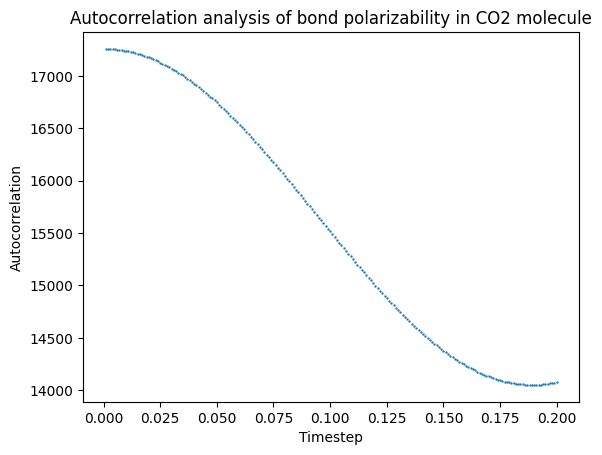

<Figure size 3500x2000 with 0 Axes>

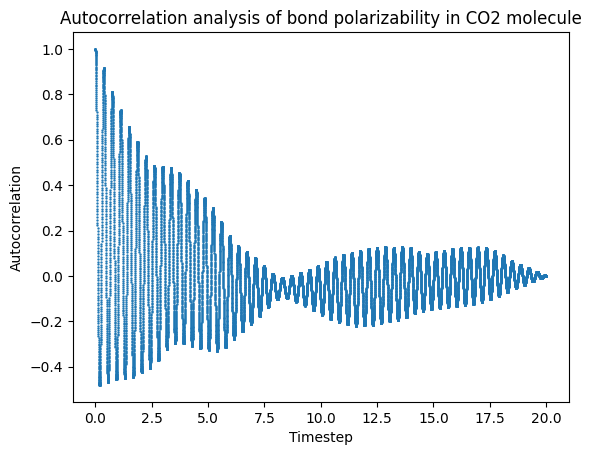

<Figure size 3500x2000 with 0 Axes>

In [711]:
fig, ax = plt.subplots();
scatter = ax.scatter(x=time_steps, y=acorr1, s=0.5);
# scatter = ax.scatter(x=time_steps, y=autocorr, s=0.5); ### For all axis polarization
plt.title(f"Autocorrelation analysis of bond polarizability in {mol} molecule");
plt.ylabel('Autocorrelation');
plt.xlabel('Timestep');
plt.figure(figsize=(35,20));
plt.show()

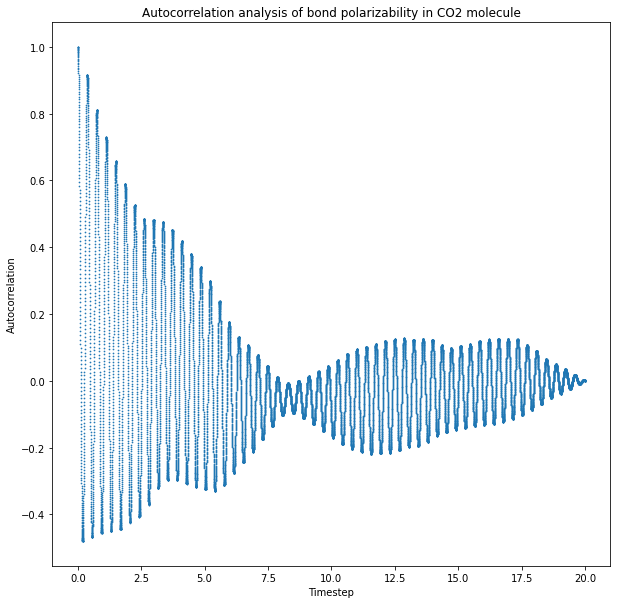

In [8]:
fig, ax = plt.subplots(figsize=(10,10));
scatter = ax.scatter(x=df.timestep, y=df.deriv, s=0.5);
# scatter = ax.scatter(x=time_steps, y=autocorr, s=0.5); ### For all axis polarization
plt.title(f"Autocorrelation analysis of bond polarizability in {mol} molecule");
plt.ylabel('Autocorrelation');
plt.xlabel('Timestep');
# plt.figure(figsize=(35,20));
plt.show()

In [74]:
import math
# Global varibales

temp = 300
# Constant
kb = 1.38064852E-23
reduced_planck = 1.05457180013E-34
lightspeed = 299792458
a = 3.3356E-11
# omega_in = 2.9979e15 * a / (100 * lightspeed)
zoom_wavenum = 4000  # cm^-1

wavelen = 532E-9
omega_in = 2 * math.pi * lightspeed / wavelen
timestep = 0.001

In [75]:
df.deriv[1:]

1        0.999802
2        0.999331
3        0.998599
4        0.997629
5        0.996445
           ...   
19995    0.000293
19996    0.000234
19997    0.000176
19998    0.000117
19999    0.000058
Name: deriv, Length: 19999, dtype: float64

In [76]:
from scipy.fftpack import fft, fftfreq

size = df.shape[0]
time_array = np.arange(0, timestep * (size - 1), timestep)

EXP_TERM = np.exp(-(omega_in * reduced_planck) / (kb * temp))

fft_autocorrelation = fft(df.deriv.values)[1:]
# fft_autocorrelation = np.fft.fft(df.deriv)[1:]

# Calculate frequency array for FFT output

# freqs = np.fft.fftfreq(size, d=timestep)[1:]
freqs = fftfreq(size, d=timestep)[1:]

# Apply scaling for FFT normalization
fft_autocorrelation = fft_autocorrelation / size

# Calculate Raman intensity using FFT results
raman_intensity = (
    (omega_in - freqs) ** 4
    / freqs
    / (1 - EXP_TERM)
    * fft_autocorrelation.real  # Extract real part
)

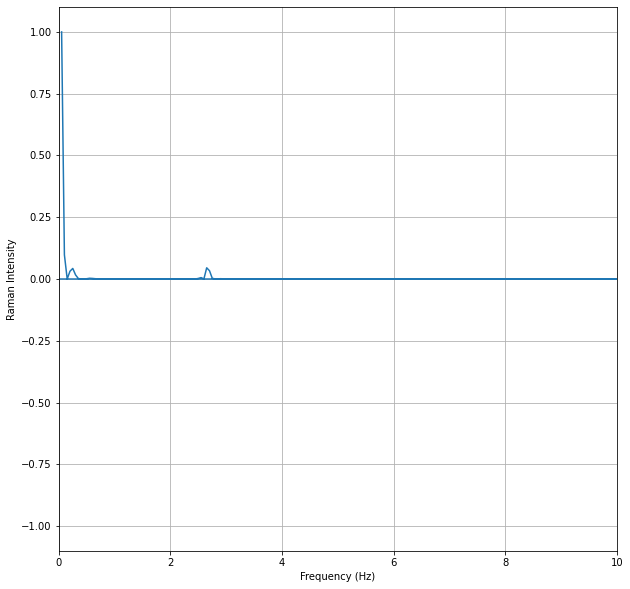

In [77]:
# plt.plot(lineshape_freq[:500], spectra_wm[:500])
# plt.plot(lineshape_freq[:20], spectra_wm[:20])


raman_intensity = raman_intensity/ max(raman_intensity)
plt.figure(figsize=(10,10));
plt.plot(freqs, raman_intensity)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Raman Intensity")
plt.xlim([0, 10])
# plt.ylim([-0.5e62, 1.5e62])
plt.grid()
plt.show()

In [66]:
freqs

array([ 0.05,  0.1 ,  0.15, ..., -0.15, -0.1 , -0.05])

In [487]:
from scipy import fftpack
from scipy.fftpack import fft, fftfreq

In [716]:
omega_in/1E15

3.540698434791077

In [864]:
# accor1 = autocorr
lineshape = fftpack.dct(acorr1, type=1)[1:]
# lineshape_freq = np.linspace(0, 0.5/(timestep), len(acorr1))[1:]
freqs = fftfreq(len(acorr1), d=timestep)[1:]
lineshape_freq_wn = lineshape_freq / (100.* lightspeed) # converts to wavenumbers (cm^-1)

spectra = lineshape * ((omega_in - lineshape_freq) ** 4) / lineshape_freq
spectra_wm = spectra / (1. - np.exp(-(lineshape_freq * reduced_planck) / (kb * temp)))

In [865]:
spectra_wm

array([8.06534847e+81, 3.69285167e+81, 7.00700269e+80, ...,
       1.44546042e+66, 4.12440823e+62, 1.44511964e+66])

In [866]:
mask = (lineshape_frequencies_wn >= 0) & (lineshape_frequencies_wn <= zoom_wavenum)

In [867]:
len(spectra_wm)

19999

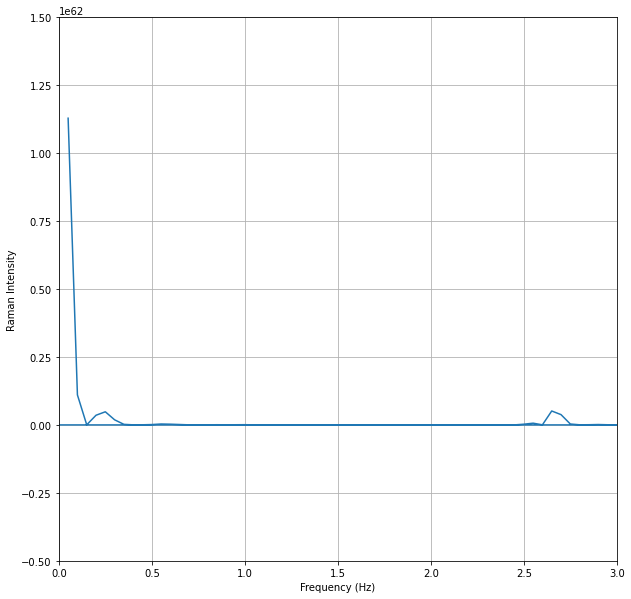

In [45]:
# plt.plot(lineshape_freq[:500], spectra_wm[:500])
# plt.plot(lineshape_freq[:20], spectra_wm[:20])
plt.figure(figsize=(10,10));
plt.plot(freqs, raman_intensity)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Raman Intensity")
plt.xlim([0, 3])
plt.ylim([-0.5e62, 1.5e62])
plt.grid()
plt.show()

In [46]:
raman_intensity

array([ 1.12833783e+62,  1.10332196e+61,  3.45576124e+58, ...,
       -3.45576124e+58, -1.10332196e+61, -1.12833783e+62])

In [762]:
lineshape_freq

array([1.25006250e+06, 2.50012501e+06, 3.75018751e+06, ...,
       2.49974999e+10, 2.49987499e+10, 2.50000000e+10])

In [740]:
np.exp(-(lineshape_freq * reduced_planck) / (kb * temp))

array([1.        , 1.        , 1.        , ..., 0.99999987, 0.99999987,
       0.99999987])

In [810]:
freqs = fftfreq(len(correlation), d=timestep)[1:]
freqs

array([ 0.05,  0.1 ,  0.15, ..., -0.15, -0.1 , -0.05])

In [721]:
spectra_wm

array([3.22613939e+82, 1.35404561e+82, 2.64708991e+81, ...,
       5.78184166e+66, 1.64974890e+63, 5.78042814e+66])

In [811]:
mask = freqs != 0
raman_intensity = (np.ma.masked_array(
    spectrum * np.exp(-1j * freqs * timesteps) * ((omega_in - freqs) ** 4),
    mask=~mask
) / freqs )/ (1 - np.exp(-(freqs * reduced_planck) / (kb * temp)))

In [813]:
max_freq_hz = 4000
max_freq_index = int(max_freq_hz * timestep / 0.5)
# spectra_wm = spectra_wm[:max_freq_index + 1]
# lineshape_freq_wn = lineshape_freq_wn[:max_freq_index + 1]
spectra_wm = spectra_wm / max(spectra_wm)

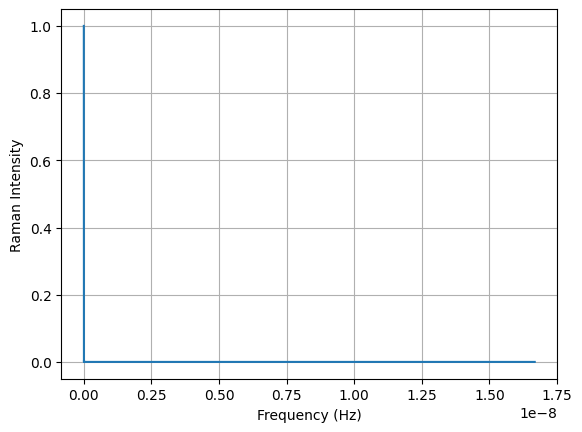

In [814]:
plt.plot(lineshape_freq_wn, spectra_wm)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Raman Intensity")
plt.grid()
plt.show()

In [862]:
spectrum = fft(correlation)[1:]
freqs = fftfreq(len(correlation), d=timestep)[1:]
mask = freqs != 0
raman_intensity = (np.ma.masked_array(
    spectrum  * np.exp(-1j * freqs * timesteps) * ((omega_in - freqs) ** 4),
    mask=~mask
) / freqs )/ (1 - np.exp(-(freqs * reduced_planck) / (kb * temp)))

In [847]:
max_freq_wn = zoom_wavenum  # Adjust as needed
max_freq_index = int(max_freq_hz * timestep / 0.5)
# raman_intensity = raman_intensity[:max_freq_index + 1]
# raman_intensity = raman_intensity[:20]
# freqs = freqs[:20]
# freqs = freqs[:max_freq_index + 1]
raman_freqs_wn = freqs / (100. * lightspeed)

masked_array(data=[(6.565983822719774e+80-1.7881573739393777e+81j),
                   (-2.031489069488575e+80-1.265215185256332e+79j),
                   (-1.0394562242197358e+79+4.5434062282272854e+79j), ...,
                   (-1.0394562242197358e+79-4.5434062282272854e+79j),
                   (-2.1238294817380558e+80+1.3227249664043472e+79j),
                   (6.018818504159792e+80+1.6391442594444295e+81j)],
             mask=[False, False, False, ..., False, False, False],
       fill_value=(1e+20+0j))

In [848]:
df = pd.DataFrame({'freqs': freqs, 'intensity': raman_intensity})

/home/sck/almaz/raman/env/lib64/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sck/almaz/raman/env/lib64/python3.9/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


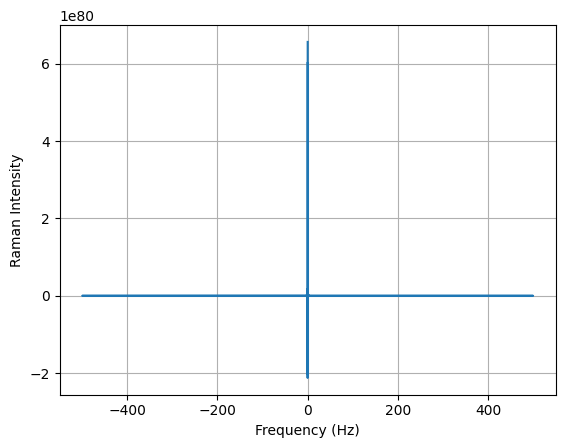

In [852]:
# Plot or further process the Raman intensity
# raman_intensity = spectra_wm / max(spectra_wm)
plt.plot(freqs, raman_intensity)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Raman Intensity")
plt.grid()
plt.show()

In [826]:
df

,freqs,intensity
0,0.05,6.565984e+80-1.788157e+ 81j
1,0.10,-2.031489e+80-1.265215e+ 79j
2,0.15,-1.039456e+79+4.543406e+ 79j
3,0.20,-5.049553e+78+1.496648e+ 79j
4,0.25,1.833148e+79+1.256132e+ 79j
...,...,...
19994,-0.25,1.801542e+79-1.234474e+ 79j
19995,-0.20,-5.049553e+78-1.496648e+ 79j
19996,-0.15,-1.039456e+79-4.543406e+ 79j
19997,-0.10,-2.123829e+80+1.322725e+ 79j


In [669]:
len(raman_intensity)

19999

In [364]:
lineshape_frequencies_wn

array([4.52826620e+04, 9.05653239e+04, 1.35847986e+05, ...,
       9.05517391e+08, 9.05562674e+08, 9.05607957e+08])

In [700]:
lineshape = fftpack.dct(acorr1, type=1)[1:]
lineshape_frequencies = np.linspace(0, 0.5/timesteps, len(acorr1))[1:]


max_freq_wn = zoom_wavenum
max_freq_hz = max_freq_wn * 3.3356E-11 * 100 * lightspeed
max_freq_index = int(max_freq_hz * timestep / 0.5)
# lineshape_frequencies = np.linspace(0, 0.5/timestep, max_freq_index + 1)[1:]
lineshape_frequencies_wn = lineshape_frequencies / (100.*lightspeed)

In [701]:
freqs = lineshape_frequencies_wn
spectrum = lineshape

In [702]:
omega_in

6.283185307179586

In [703]:
# raman_intensity = (
#     spectrum
#     * np.exp(-1j * freqs * timesteps)
#     * (omega_in - freqs) ** 4 
#     / freqs 
#     / (1 - np.exp(-(freqs * reduced_planck)/(kb * temp)))
# )
mask = freqs != 0

raman_intensity = np.ma.masked_array(
    spectrum * np.exp(-1j * freqs * timesteps) * ((omega_in - freqs) ** 4),
    mask=~mask
) / freqs / (1 - np.exp(-(freqs * reduced_planck) / (kb * temp)))

In [465]:
# mask = (lineshape_frequencies_wn >= 0) & (lineshape_frequencies_wn <= zoom_wavenum)

In [496]:
raman_intensity

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=(1e+20+0j),
            dtype=complex128)

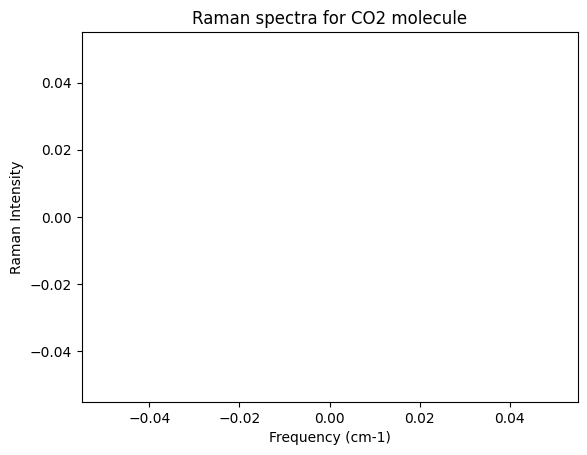

In [704]:
# Plot or further process the Raman intensity
plt.plot(lineshape_frequencies_wn, np.abs(raman_intensity))
plt.title(f"Raman spectra for {mol} molecule");
plt.xlabel("Frequency (cm-1)")
plt.ylabel("Raman Intensity")
# plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [228]:
print(len(raman_intensity))

19999


In [281]:
def slicer(data, slice_to=2):
    return(data[: (len(data) // slice_to)])

In [282]:
raman_intensity = slicer(raman_intensity)
# freqs = slicer(freqs)
l_freq_wn = slicer(lineshape_frequencies_wn)
mask = slicer(mask)

In [279]:
raman_intensity

masked_array(data=[--, --, --, ...,
                   (1.7950018019483048e+75-5.592005581674535e+74j),
                   (-4.472178696640513e+72+1.3933751301126135e+72j),
                   (1.7938000965993732e+75-5.589450881565401e+74j)],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=(1e+20+0j))

In [552]:
plt.plot(l_freq_wn[mask], np.abs(raman_intensity)[mask])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Raman Intensity")
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 9999 but corresponding boolean dimension is 20000